In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import metrics
import scipy.stats as stats
import os
import calendar
from datetime import datetime
import collections

sns.set_style('darkgrid')
sns.set(font_scale=1.5)

# Data Loading

In [2]:
videos_df = pd.read_pickle('US_trending.pkl')

In [3]:
videos_df.head()

,video_id,title,published_at,channel_id,channel_title,category_id,trending_date,tags,view_count,likes,...,description,days_in_trending,category_name,publish_to_trend,publishing_hour,publishing_day,positive_sentiment,negative_sentiment,neutral_sentiment,analyzed_comments
0,vPx6M7eTYbc,Spill Your Guts: Harry Styles & Kendall Jenner,2019-12-11 07:08:34,UCJ0uqCI0Vqr2Rrt1HseGirg,The Late Late Show with James Corden,24,2019-12-12,The Late Late Show|Late Late Show|James Corden...,11636632,571835,...,Late Late Show guest host Harry Styles challen...,1,Entertainment,1,7,Wednesday,0.468750,0.131250,0.400000,160.0
1,sg8WaeeFyNY,WE GOT UNEXPECTED NEWS..,2019-12-12 05:25:42,UCDSJCBYqL7VQrlXfhr1RtwA,Les Do Makeup,26,2019-12-12,[none],423215,52780,...,Hi babygirls! Thank you so much for watching ...,7,How-to & Style,0,5,Thursday,0.750000,0.075000,0.175000,40.0
2,q1PR05q8l2g,"Last To Miss Layup Wins $10,000",2019-12-11 23:00:53,UCQIUhhcmXsu6cN6n3y9-Pww,Jesser,17,2019-12-12,last to leave|nba basketball|nba basketball hi...,463685,20178,...,"Last to miss the basketball shot wins 10,000!●...",7,Sport,1,23,Wednesday,0.318182,0.181818,0.500000,88.0
3,t6Z6RIXq0L0,LAKERS at MAGIC | FULL GAME HIGHLIGHTS | Decem...,2019-12-12 02:35:33,UCWJ2lWNubArHWmf3FIHbfcQ,NBA,17,2019-12-12,sp:ty=high|sp:dt=2019-12-12T00:00:00Z|sp:st=ba...,659579,4605,...,LAKERS at MAGIC | FULL GAME HIGHLIGHTS | Decem...,2,Sport,0,2,Thursday,0.462069,0.193103,0.344828,145.0
4,TGDpRB4ovvA,TIPPING DRIVE-THRU WORKERS $100 FOR THE HOLIDA...,2019-12-12 02:38:37,UCtj45MepAoKxZoyR_Mnt86Q,Royal Family,24,2019-12-12,queen Naija|Medicine|Queen|Spicy|Royalty Squad...,175558,18400,...,LAST VIDEO ; https://youtu.be/okujHUu_hmQ*MAKE...,6,Entertainment,0,2,Thursday,0.631250,0.131250,0.237500,160.0


## Dealing with missing values

In [4]:
# ovde mozda razmisliti o necemu boljem (srednja vrednost po kategoriji i slicno)
videos_df['positive_sentiment'] = videos_df['positive_sentiment'].fillna(videos_df['positive_sentiment'].mean())
videos_df['negative_sentiment'] = videos_df['negative_sentiment'].fillna(videos_df['negative_sentiment'].mean())
videos_df['neutral_sentiment'] = videos_df['neutral_sentiment'].fillna(videos_df['neutral_sentiment'].mean())
videos_df.isna().sum()

video_id               0
title                  0
published_at           0
channel_id             0
channel_title          0
category_id            0
trending_date          0
tags                   0
view_count             0
likes                  0
dislikes               0
comment_count          0
thumbnail_link         0
comments_disabled      0
ratings_disabled       0
description           12
days_in_trending       0
category_name          0
publish_to_trend       0
publishing_hour        0
publishing_day         0
positive_sentiment     0
negative_sentiment     0
neutral_sentiment      0
analyzed_comments      0
dtype: int64

### X and y arrays

In [5]:
set(videos_df['category_name'])  # provera, ovde se desavala glupost kad se eksportuje u CSV

{'Autos & Vehicles',
 'Comedy',
 'Education',
 'Entertainment',
 'Film & Animation',
 'Gaming',
 'How-to & Style',
 'Music',
 'News & Politics',
 'People & Blogs',
 'Pets & Animals',
 'Science & Technology',
 'Sport',
 'Travel & Events'}

In [6]:
X = videos_df[['view_count', 'dislikes', 'comment_count', 'positive_sentiment', 'negative_sentiment', 'category_id']]
y = videos_df['likes']

### One Hot Encoding for category feature

In [7]:
#category_dummies = pd.get_dummies(videos_df['category_name'])
#X = pd.concat([X, category_dummies], axis=1)
#X.head()

onehotencoder = OneHotEncoder(categorical_features = [5]) 
X = onehotencoder.fit_transform(X).toarray() 
X.size

C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


43586

### Split data into training and test sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

### Feature Scaling

In [9]:
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

#scaler_y = MinMaxScaler()
#y_train = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1))
#y_test = scaler_y.transform(np.array(y_test).reshape(-1, 1))

# Linear regression

In [10]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [11]:
print(lin_reg.score(X_test, y_test))

0.8949056095983378


Text(0, 0.5, 'Predicted Y')

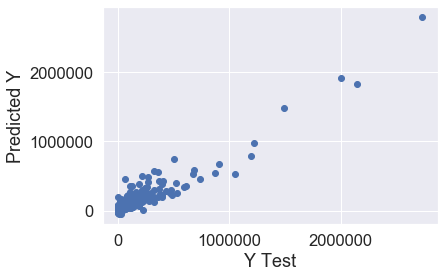

In [12]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [13]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', lin_reg.score(X_train, y_train))
print('R squared on test set: ', lin_reg.score(X_test, y_test))

MAE: 35691.58635703919
MSE: 4343793192.86357
RMSE: 65907.45931124617
R squared on training set:  0.8290780960687796
R squared on test set:  0.8949056095983378


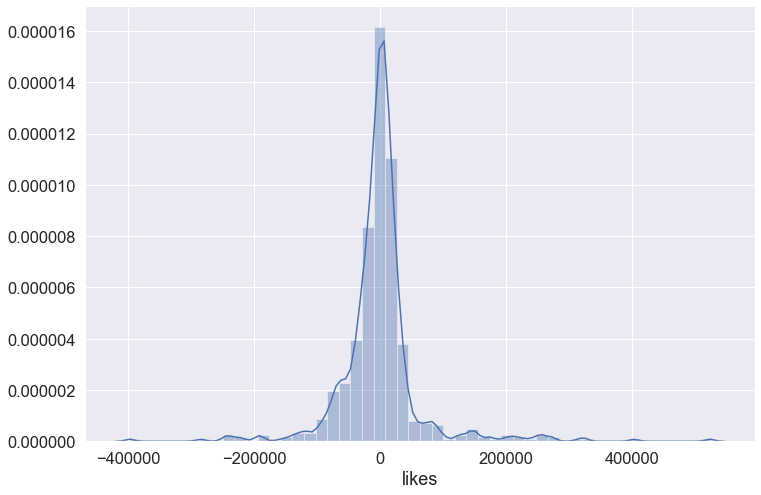

In [14]:
# residual histogram
plt.figure(figsize=(12, 8))
sns.distplot((y_test-y_pred), bins=50);

# Napomena: Rigde i GradientBoosting ce verovatno bolje raditi kad bude vise feature-a

# Ridge regression with Grid Search

In [15]:
ridge_reg = Ridge(solver='cholesky')

In [16]:
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
ridge_regressor = GridSearchCV(estimator=ridge_reg, param_grid=parameters, cv=5)
ridge_regressor.fit(X_train, y_train)
print(ridge_regressor.best_score_)
print(ridge_regressor.best_estimator_)

0.668708065049375
Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='cholesky', tol=0.001)


C:\Users\Marko\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.14919e-17): result may not be accurate.
  overwrite_a=True).T


In [17]:
y_pred = ridge_regressor.predict(X_test)

Text(0, 0.5, 'Predicted Y')

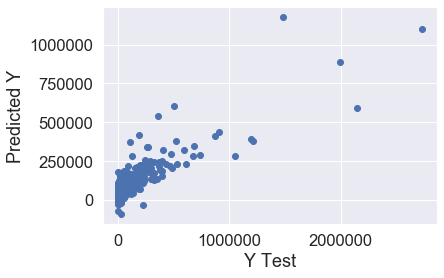

In [18]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [19]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', ridge_regressor.score(X_train, y_train))
print('R squared on test set: ', ridge_regressor.score(X_test, y_test))

MAE: 47653.917311014586
MSE: 16612330951.249702
RMSE: 128888.83175531424
R squared on training set:  0.7092174083900651
R squared on test set:  0.5980787489283479


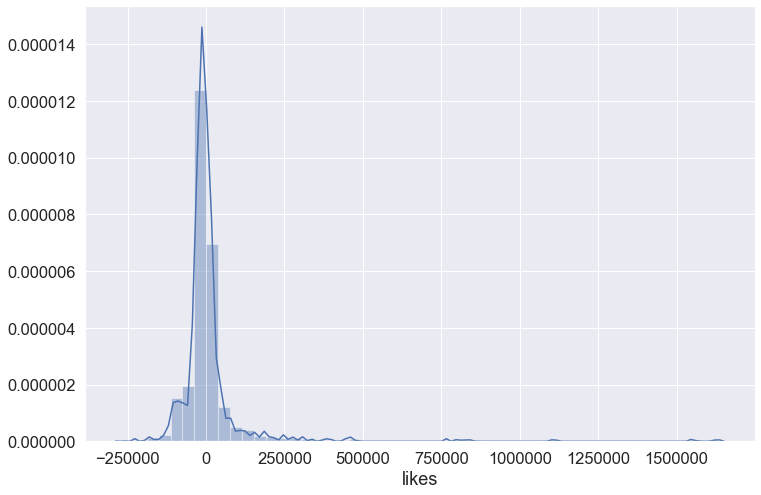

In [20]:
# residual histogram
plt.figure(figsize=(12, 8))
sns.distplot((y_test-y_pred), bins=50);

# Gradient Boosting regression with Grid Search

In [34]:
grad_boost_reg = GradientBoostingRegressor()

In [35]:
parameters = {#'learning_rate': [0.1, 0.2, 0.3],
              'subsample': [0.9, 0.5, 0.2],
              'n_estimators': [50, 100, 1000, 1000],
              'max_depth': [3, 6, 8],
              'learning_rate': [0.1],# 0.05, 0.02, 0.01
              'alpha': [1e-15, 1e-10, 1e-5, 1e-3, 1e-2]}
grid = GridSearchCV(estimator=grad_boost_reg, param_grid=parameters, cv=5)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_estimator_)

0.8373182191807498
GradientBoostingRegressor(alpha=0.001, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.2, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [36]:
y_pred = grid.predict(X_test)

Text(0, 0.5, 'Predicted Y')

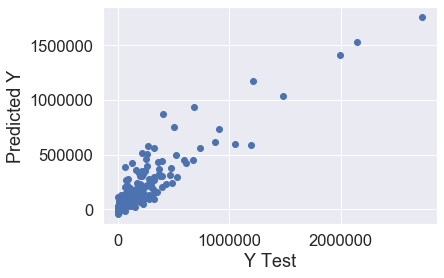

In [37]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [38]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', grid.score(X_train, y_train))
print('R squared on test set: ', grid.score(X_test, y_test))

MAE: 34947.844588245855
MSE: 6977743171.4061985
RMSE: 83532.88676566971
R squared on training set:  0.9733529850372029
R squared on test set:  0.8311794248899621


# Support Vector Regression with Grid Search

In [39]:
svr = SVR()

In [40]:
parameters = {'kernel': ('linear', 'rbf','poly'), 
              'C': [1e0, 1e1, 1e2, 1e3],
              'gamma': np.logspace(-2, 2, 5),
              'epsilon':[0.1, 0.3, 0.5]
             }
svr_regressor = GridSearchCV(estimator=svr, param_grid=parameters, cv=5)
svr_regressor.fit(X_train, y_train)
print(svr_regressor.best_score_)
print(svr_regressor.best_estimator_)

0.8024676426608175
SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=100.0,
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [41]:
y_pred = svr_regressor.predict(X_test)

Text(0, 0.5, 'Predicted Y')

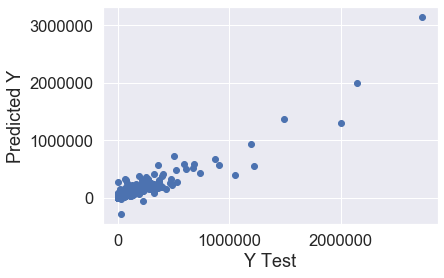

In [42]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [43]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', svr_regressor.score(X_train, y_train))
print('R squared on test set: ', svr_regressor.score(X_test, y_test))

MAE: 29482.18302848486
MSE: 5262553259.027787
RMSE: 72543.45772726709
R squared on training set:  0.8880150854843938
R squared on test set:  0.8726769894058406


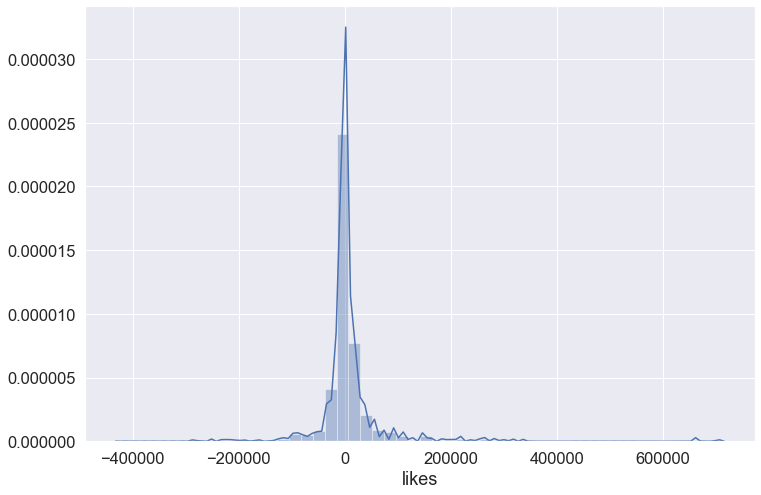

In [44]:
# residual histogram
plt.figure(figsize=(12, 8))
sns.distplot((y_test-y_pred), bins=50);

# Kernel Ridge Regression with Grid Search

In [45]:
kernel_ridge = KernelRidge()

In [46]:
parameters = {'kernel': ('linear', 'rbf','poly'), 
              'alpha': [1e0, 0.1, 1e-2, 1e-3],
              'gamma': np.logspace(-2, 2, 5)}
krr_regressor = GridSearchCV(estimator=kernel_ridge, param_grid=parameters, cv=5)
krr_regressor.fit(X_train, y_train)
print(krr_regressor.best_score_)
print(krr_regressor.best_estimator_)

0.794589416038724
KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1, kernel='rbf',
            kernel_params=None)


In [47]:
y_pred = krr_regressor.predict(X_test)

Text(0, 0.5, 'Predicted Y')

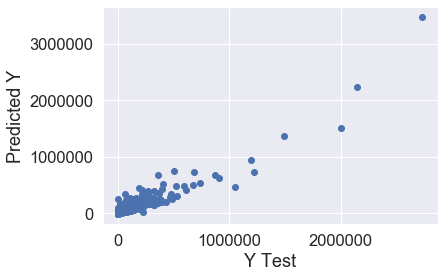

In [48]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [49]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', krr_regressor.score(X_train, y_train))
print('R squared on test set: ', krr_regressor.score(X_test, y_test))

MAE: 31736.819969792152
MSE: 4868990691.281683
RMSE: 69778.15339546958
R squared on training set:  0.8921626803625896
R squared on test set:  0.8821989017773002


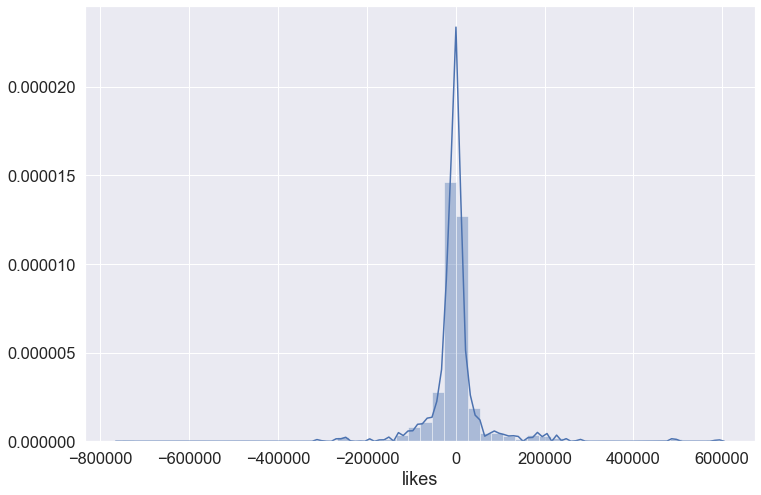

In [50]:
# residual histogram
plt.figure(figsize=(12, 8))
sns.distplot((y_test-y_pred), bins=50);

# Random Forest Regression with Grid Search

In [13]:
random_forest = RandomForestRegressor()

In [26]:
parameters = {'n_estimators': [140, 160, 180, 200, 220],
              'max_depth': [10, 15, 20]}
rand_forest_regressor = GridSearchCV(estimator=random_forest, param_grid=parameters, cv=5)
rand_forest_regressor.fit(X_train, y_train)
print(rand_forest_regressor.best_score_)
print(rand_forest_regressor.best_estimator_)

0.8162887326974451
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=180,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [23]:
y_pred = rand_forest_regressor.predict(X_test)

Text(0, 0.5, 'Predicted Y')

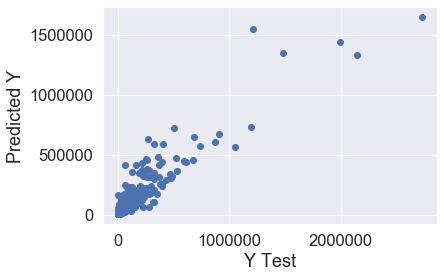

In [24]:
plt.scatter(y_test, y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [25]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R squared on training set: ', rand_forest_regressor.score(X_train, y_train))
print('R squared on test set: ', rand_forest_regressor.score(X_test, y_test))

MAE: 32520.06831028012
MSE: 6839949710.819961
RMSE: 82703.98848193453
R squared on training set:  0.9675265908033335
R squared on test set:  0.8345132207450313
